In [63]:
import pandas as pd
import numpy as np

train = pd.read_csv(r"train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


29.69911764705882
28.0
0    24.0
Name: Age, dtype: float64


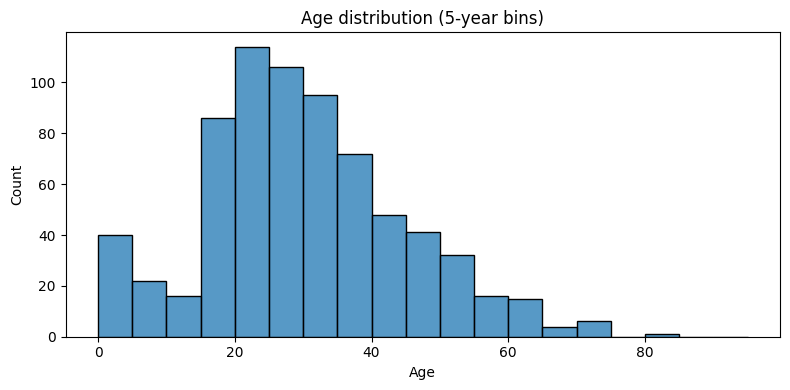

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

ages = train['Age']
print(ages.mean())
print(ages.median())
print(ages.mode())

plt.figure(figsize = (8,4))
sns.histplot(ages.dropna(), bins = np.arange(0, 100, 5), kde = False, color = "C0")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution (5-year bins)')
plt.tight_layout()
plt.show()

In [66]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer



In [67]:
print(train.nunique())

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [68]:
def remove_unessential (df: pd.DataFrame):
    return df.drop(columns = ["Name", "Ticket", "Cabin"])

def create_title (df: pd.DataFrame):
    df = df.__deepcopy__()
    df["Title"] = (df["Name"].astype(str).str.extract(r',\s*([^\.]+)\.', expand=False).str.strip().replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"}))
    return df

def replace_title (df: pd.DataFrame):
    df = df.__deepcopy__()
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title
    df['Title']=df.apply(replace_titles, axis=1)
    return df
    
rm_unessential_T = FunctionTransformer(remove_unessential)
create_title_T = FunctionTransformer(create_title)
replace_title_T = FunctionTransformer(replace_title)


In [69]:
returned = create_title_T.fit_transform(train)
returned = replace_title_T.fit_transform(returned)
returned.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [70]:
returned["Title"].value_counts()

Title
Mr              530
Miss            185
Mrs             133
Master           40
Lady              1
Sir               1
the Countess      1
Name: count, dtype: int64

In [75]:
num_cols = ["Fare", "Age", "Pclass", "SibSp", "Parch"]
cat_ordinal_cols = [ "Sex", "Ticket"]
cat_onehot_cols = ["Embarked", "Title"]

feature_engineering = make_pipeline(
    create_title_T,
    replace_title_T,
    replace_title_T
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
)

cat_ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
)

cat_onehot_pipeline = make_pipeline(
    SimpleImputer(strategy= 'most_frequent'),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessor_ct = make_column_transformer(
    (num_pipeline, num_cols),
    (cat_ordinal_pipeline, cat_ordinal_cols),
    (cat_onehot_pipeline, cat_onehot_cols),
    remainder = "drop"
)

preprocessor = make_pipeline(
    feature_engineering,
    preprocessor_ct
)
preprocessor.set_output(transform = "pandas")
train_y = train["Survived"]
train_X = train.drop(columns=["Survived"])

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

train_X = preprocessor.fit_transform(train_X)
train_X.head()

,pipeline-1__Fare,pipeline-1__Age,pipeline-1__Pclass,pipeline-1__SibSp,pipeline-1__Parch,pipeline-2__Sex,pipeline-2__Ticket,pipeline-3__Embarked_C,pipeline-3__Embarked_Q,pipeline-3__Embarked_S,pipeline-3__Title_Lady,pipeline-3__Title_Master,pipeline-3__Title_Miss,pipeline-3__Title_Mr,pipeline-3__Title_Mrs,pipeline-3__Title_Sir,pipeline-3__Title_the Countess
0,7.2500,22.0,3.0,1.0,0.0,1.0,523.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,71.2833,38.0,1.0,1.0,0.0,0.0,596.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7.9250,26.0,3.0,0.0,0.0,0.0,669.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,53.1000,35.0,1.0,1.0,0.0,0.0,49.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8.0500,35.0,3.0,0.0,0.0,1.0,472.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
np.mean(cross_val_score(XGBClassifier(n_estimators = 200, max_depth = 6, n_jobs = -1), train_X, train_y, cv = 5, n_jobs = -1, scoring="accuracy"))

np.float64(0.8126106333563492)